In [1]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
games_dataset = pd.read_csv('vgsales.csv')
games_dataset.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


# Analazying dataset

In [3]:
print('Genre:', len(games_dataset.Genre.unique()))
print('Platform:', len(games_dataset.Platform.unique()))
print('Publisher:', len(games_dataset.Publisher.unique()))

Genre: 12
Platform: 31
Publisher: 579


<AxesSubplot: >

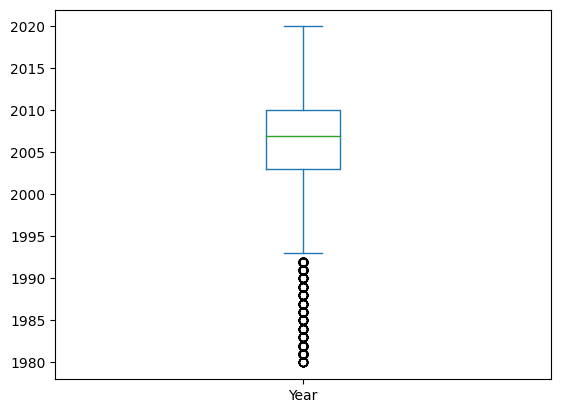

In [4]:
games_dataset['Year'].plot.box()

In [5]:
games_dataset.describe()

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16598.000000,16327.000000,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000
mean,8300.605254,2006.406443,0.264667,0.146652,0.077782,0.048063,0.537441
std,4791.853933,5.828981,0.816683,0.505351,0.309291,0.188588,1.555028
min,1.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4151.250000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8300.500000,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12449.750000,2010.000000,0.240000,0.110000,0.040000,0.040000,0.470000
max,16600.000000,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


C:\Users\kryst\AppData\Local\Temp\ipykernel_9284\3919070972.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = games_dataset.corr()


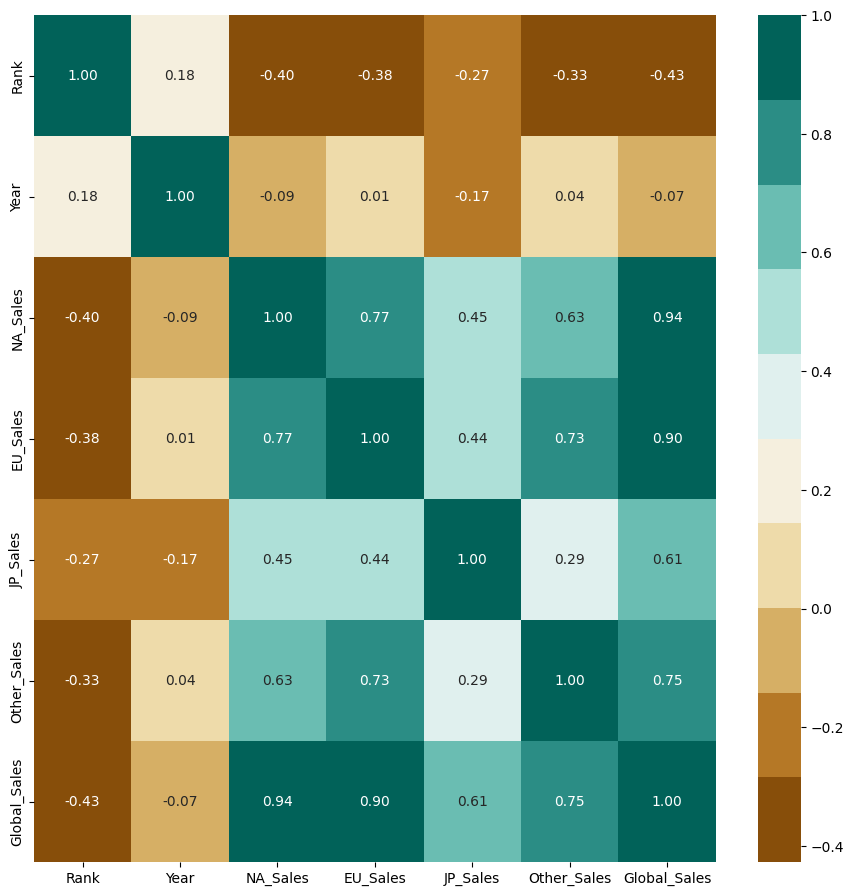

In [6]:
# Correlation before normalization

correlations = games_dataset.corr()
fig, ax = plt.subplots(figsize=(len(games_dataset.columns), len(games_dataset.columns)))

colormap = sns.color_palette("BrBG", 10)

sns.heatmap(correlations, 
    cmap=colormap, 
    annot=True, 
    fmt=".2f")

plt.show()

# Deleting unnecessary columns

In [7]:
games_dataset.drop('Name', inplace=True, axis=1)
games_dataset.drop('Rank', inplace=True, axis=1)
games_dataset.drop('NA_Sales', inplace = True, axis = 1)
games_dataset.drop('EU_Sales', inplace = True, axis = 1)
games_dataset.drop('JP_Sales', inplace = True, axis = 1)
games_dataset.drop('Other_Sales', inplace = True, axis = 1)
games_dataset.head(5)

,Platform,Year,Genre,Publisher,Global_Sales
0,Wii,2006.0,Sports,Nintendo,82.74
1,NES,1985.0,Platform,Nintendo,40.24
2,Wii,2008.0,Racing,Nintendo,35.82
3,Wii,2009.0,Sports,Nintendo,33.00
4,GB,1996.0,Role-Playing,Nintendo,31.37


In [8]:
# Dropping unnecessarily scarce data ( insignificant for model )

games_dataset = games_dataset.drop(games_dataset[games_dataset.Year < 1995].index)
games_dataset = games_dataset.drop(games_dataset[games_dataset.Year > 2019].index)

<AxesSubplot: >

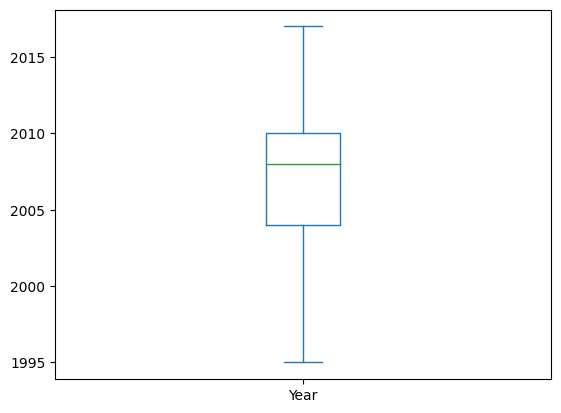

In [9]:
games_dataset['Year'].plot.box()

# Normalizing useful data to int types

In [10]:
# Function to convert useful data to int types in order

def convert_to_int_range(df, column_name):
    column_list = df[column_name].unique()
    
    column_dict = {}
    
    for i in range(len(column_list)):
        column_dict[column_list[i]] = i + 1
        
    return df.replace(column_dict.keys(), column_dict.values())

In [11]:
games_dataset = convert_to_int_range(games_dataset, 'Platform')
games_dataset = convert_to_int_range(games_dataset, 'Publisher')
games_dataset = convert_to_int_range(games_dataset, 'Genre')
games_dataset = games_dataset.reset_index(drop=True)
games_dataset.head(5)

,Platform,Year,Genre,Publisher,Global_Sales
0,1,2006.0,1,1,82.74
1,1,2008.0,2,1,35.82
2,1,2009.0,1,1,33.00
3,2,1996.0,3,1,31.37
4,3,2006.0,4,1,30.01


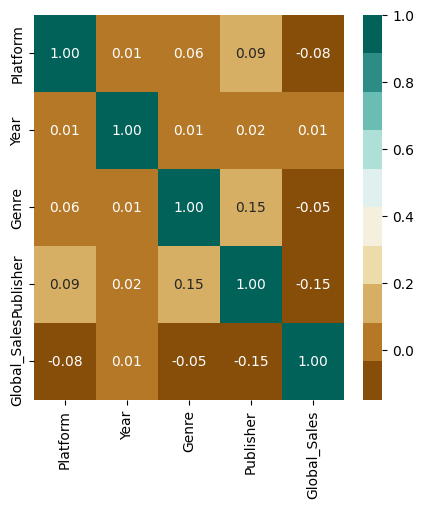

In [12]:
# Correlation after normalization

correlations = games_dataset.corr()
fig, ax = plt.subplots(figsize=(len(games_dataset.columns), len(games_dataset.columns)))

colormap = sns.color_palette("BrBG", 10)

sns.heatmap(correlations, 
    cmap=colormap, 
    annot=True, 
    fmt=".2f")

plt.show()

# Training models

In [13]:
X = games_dataset.drop('Global_Sales', axis=1).to_numpy()
y = games_dataset.loc[:, 'Global_Sales'].to_numpy()

In [14]:
# Distributioning the dataset into training and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345) 

In [15]:
# Function for training and evaluating models

def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    classifier.fit(feature_vector_train, label)
    with open('titanic_classifier.pickle', 'wb') as handle:
        pickle.dump(classifier, handle)
    predictions = classifier.predict(feature_vector_valid)
    score_vals = [
        metrics.mean_squared_error(predictions, y_test),
        metrics.mean_absolute_error(predictions, y_test)
    ]
    return score_vals

In [16]:
# Model 1

accuracy = train_model(linear_model.LinearRegression(), X_train, y_train, X_test)
accuracy_compare = {'LR': accuracy}
print ("LR: ", accuracy)

LR:  [1.0383518125484654, 0.5254083407477447]


In [17]:
# Model 2

regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
accuracy = train_model(regressor, X_train, y_train, X_test)
accuracy_compare['random forrest tree'] = accuracy
print ('random forrest tree' , accuracy)

random forrest tree [2.16410868922142, 0.48219860888013083]


In [18]:
# Model 3

regressor = RandomForestRegressor(n_estimators = 300, random_state = 0)
accuracy = train_model(regressor, X_train, y_train, X_test)
accuracy_compare['random forrest tree improved'] = accuracy
print ('random forrest tree improved' , accuracy)

random forrest tree improved [2.0931712590107985, 0.4800013071248595]


# Comparing models

<AxesSubplot: >

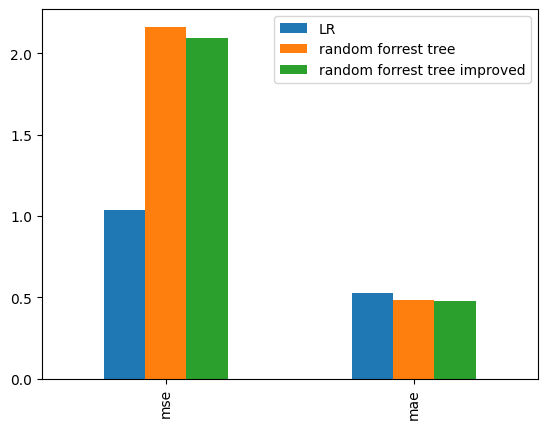

In [19]:
df_compare = pd.DataFrame(accuracy_compare, index = ['mse', 'mae'])
df_compare.plot(kind='bar')

# Manual test

In [20]:
#format regressor.predict([[Platform, Year, Genre, Publisher]])

regressor.predict([[3, 2019, 2, 1]])

array([4.82333368])

In [21]:
games_dataset.describe()


,Platform,Year,Genre,Publisher,Global_Sales
count,16111.000000,16111.000000,16111.000000,16111.000000,16111.000000
mean,8.123642,1973.734343,5.857923,58.932965,0.512733
std,5.243646,253.903513,3.338969,94.850012,1.469237
min,1.000000,33.000000,1.000000,1.000000,0.010000
25%,4.000000,2003.000000,3.000000,8.000000,0.060000
50%,6.000000,2007.000000,6.000000,21.000000,0.170000
75%,12.000000,2010.000000,8.000000,52.000000,0.460000
max,69.000000,2017.000000,12.000000,549.000000,82.740000
